In [ ]:
###1 Dataset and Task

1.1 
Dataset Overview: 
For this project, we have selected the AI4I 2020 Predictive Maintenance Dataset, a synthetic dataset that is publicly available and reflects the type of data typically encountered in industrial predictive maintenance scenarios. This dataset includes 10,000 instances and 14 features, ensuring a comprehensive set for analysis. The dataset was constructed to simulate real-world data while being freely accessible for educational and research purposes.

Source: 
The dataset is available on Kaggle and was originally provided by the UCI Machine Learning Repository. For more details, see the dataset on Kaggle.

Features: UID: 
A unique identifier for each instance. Product ID: Categorical variable representing product quality (Low, Medium, High). Type: Machine type. Air temperature [K]: Operating temperature of the machine. Process temperature [K]: Temperature recorded during the manufacturing process. Rotational speed [rpm]: Speed at which the machine operates. Torque [Nm]: Resistance force of the machine. Tool wear [min]: Indicates how much the machine's tools have worn.

Challenges and Limitations: 
The dataset is synthetic, which means it might not capture all the nuances of real-world data. Predicting outcomes based solely on operational parameters without considering external factors such as environmental conditions or operator errors could limit the model's applicability in real scenarios.

1.2 
Predictive Classification Task Target Variable: 
The main variable of interest is ‘Machine failure’, which is a binary indicator (0 = no failure, 1 = failure). This project will focus on predicting machine failure based on operational parameters, which is crucial for minimizing downtime in industrial settings.

Relevance of the Task: 
Predictive maintenance is vital in manufacturing and production industries as it helps in predicting equipment failures before they occur, thereby saving costs and preventing downtime. By using machine learning models to predict potential failures, maintenance can be scheduled at optimal times without halting the entire production line.

Potential Challenges: 
Imbalance in the dataset with respect to the target variable (failure vs. no failure) could affect the performance of the classification models. The need to accurately capture the relationship between the predictors and the machine failure without overfitting to the synthetic nature of the data. This task not only aids in understanding the critical parameters influencing machine health but also enhances the decision-making process regarding maintenance schedules and operational protocols.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
file_path = 'ai4i2020.csv'
data = pd.read_csv(file_path)

# Define features and target variable
X = data.drop(columns=['UDI', 'Product ID', 'Machine failure'])
y = data['Machine failure']

In [ ]:
###2 Preprocessing

Number of rows with outliers: 388


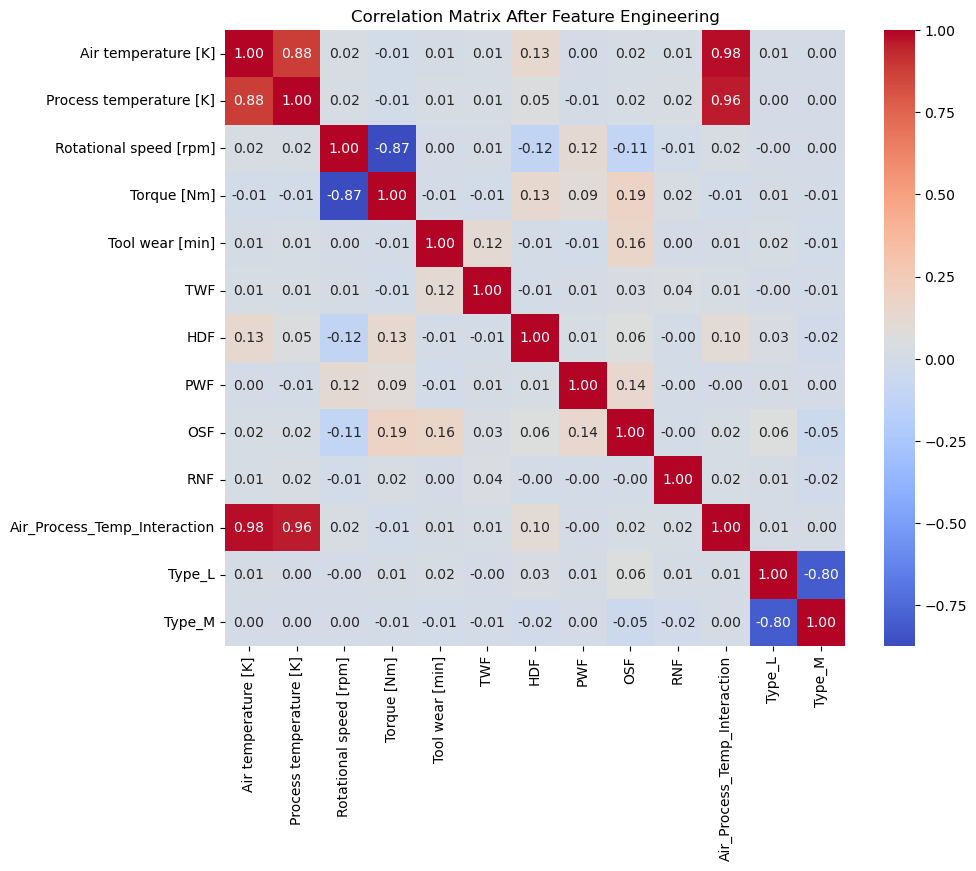

In [3]:
#2.1
# Split data into training and testing sets with an 80/20 split and stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


#2.2
# Outlier detection using Z-score method (absolute value > 3)
z_scores = np.abs((X_train - X_train.mean(numeric_only=True)) / X_train.std(numeric_only=True))
outliers = (z_scores > 3).sum(axis=1)
outlier_counts = (outliers > 0).sum()
print(f"Number of rows with outliers: {outlier_counts}")

# Feature Engineering: Adding interaction term
X_train['Air_Process_Temp_Interaction'] = X_train['Air temperature [K]'] * X_train['Process temperature [K]']
X_test['Air_Process_Temp_Interaction'] = X_test['Air temperature [K]'] * X_test['Process temperature [K]']

# Apply one-hot encoding to categorical column
X_train_encoded = pd.get_dummies(X_train, columns=['Type'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['Type'], drop_first=True)

# Dimensionality Reduction using PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_encoded)
X_test_pca = pca.transform(X_test_encoded)

# Correlation Analysis for Collinear Features
correlation_matrix = pd.DataFrame(X_train_encoded).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix After Feature Engineering")
plt.show()

# Remove Collinear Features with correlation > 0.9
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
X_train_reduced = X_train_encoded.drop(columns=to_drop)
X_test_reduced = X_test_encoded.drop(columns=to_drop)

# Feature Selection using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_reduced, y_train)
X_test_selected = selector.transform(X_test_reduced)

# Scaling and Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Custom transformer for log transformation
from sklearn.base import TransformerMixin
class LogTransformer(TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for feature in self.features:
            X[feature] = np.log1p(X[feature])
        return X

In [7]:
#2.3, 2.4

# Define various sequences of preprocessing steps
sequences = {
    "Sequence 1": Pipeline([
        ('log_transform', LogTransformer(features=['Torque [Nm]'])),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95, random_state=42)),
        ('feature_selector', SelectKBest(score_func=f_classif, k='all')),
        ('classifier', LogisticRegression(solver='liblinear', random_state=42))
    ]),
    "Sequence 2": Pipeline([
        ('log_transform', LogTransformer(features=['Torque [Nm]'])),
        ('feature_selector', SelectKBest(score_func=f_classif, k='all')),
        ('pca', PCA(n_components=0.95, random_state=42)),
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "Sequence 3": Pipeline([
        ('log_transform', LogTransformer(features=['Torque [Nm]'])),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95, random_state=42)),
        ('classifier', LogisticRegression(solver='liblinear', random_state=42))
    ])
}

# Evaluate each sequence of preprocessing steps
results = {}
for name, sequence in sequences.items():
    sequence.fit(X_train_reduced, y_train)
    y_pred = sequence.predict(X_test_reduced)
    y_proba = sequence.predict_proba(X_test_reduced)[:, 1]

    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results[name] = {'F1 Score': f1, 'Accuracy': accuracy, 'AUC': auc}

# Display results in a DataFrame
results_df = pd.DataFrame(results).T
print("\nPerformance Comparison of Preprocessing Sequences:")
print(results_df)

# Select the best sequence based on performance (Sequence 3) for further steps
best_sequence_pipeline = Pipeline([
    ('log_transform', LogTransformer(features=['Torque [Nm]'])),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42))
])
print("\nProceeding with the best sequence (Sequence 3)...")


Performance Comparison of Preprocessing Sequences:
            F1 Score  Accuracy       AUC
Sequence 1  0.985075    0.9990  0.973062
Sequence 2  0.262626    0.9635  0.829170
Sequence 3  0.985075    0.9990  0.973062

Proceeding with the best sequence (Sequence 3)...


In [9]:
#2.5

# Fit the sequence on the training data and transform both training and test sets
X_train_processed = best_sequence_pipeline.fit_transform(X_train_reduced, y_train)
X_test_processed = best_sequence_pipeline.transform(X_test_reduced)

In [ ]:
###3 Model Training and Testing

In [11]:
#3.1

# Define classifiers and their hyperparameter grids with reduced search space for efficiency
classifiers = {
    "Logistic Regression": (LogisticRegression(solver='liblinear', random_state=42), {
        'classifier__C': [0.01, 0.1, 1, 10]
    }),
    "Random Forest": (RandomForestClassifier(random_state=42), {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    }),
    "SVM": (SVC(probability=True, random_state=42), {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    }),
    "K-Nearest Neighbors": (KNeighborsClassifier(), {
        'classifier__n_neighbors': [3, 5, 7]
    }),
    "Gradient Boosting": (GradientBoostingClassifier(random_state=42), {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.1, 0.2],
        'classifier__max_depth': [3, 5]
    })
}

# Set up results dictionary
best_models = {}
results = {}

# Loop through classifiers and perform hyperparameter optimization
for clf_name, (clf, params) in classifiers.items():
    # Create pipeline using the classifier (preprocessing already applied)
    pipeline = Pipeline([
        ('classifier', clf)
    ])
    
    # Perform RandomizedSearchCV with fewer iterations (n_iter=5)
    search = RandomizedSearchCV(pipeline, param_distributions=params, scoring='roc_auc', cv=2, n_iter=5, random_state=42)
    search.fit(X_train_processed, y_train)
    
    # Store the best model and performance metrics
    best_models[clf_name] = search.best_estimator_
    y_pred = search.predict(X_test_processed)
    y_proba = search.predict_proba(X_test_processed)[:, 1]
    
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    results[clf_name] = {'Best Params': search.best_params_, 'F1 Score': f1, 'Accuracy': accuracy, 'AUC': auc}

# Convert results to DataFrame for readability
results_df = pd.DataFrame(results).T
print("\nPerformance Comparison of Classification Techniques with Hyperparameter Optimization:")
print(results_df)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Performance Comparison of Classification Techniques with Hyperparameter Optimization:
                                                           Best Params  \
Logistic Regression                               {'classifier__C': 1}   
Random Forest        {'classifier__n_estimators': 50, 'classifier__...   
SVM                  {'classifier__kernel': 'linear', 'classifier__...   
K-Nearest Neighbors                     {'classifier__n_neighbors': 7}   
Gradient Boosting    {'classifier__n_estimators': 50, 'classifier__...   

                     F1 Score Accuracy       AUC  
Logistic Regression  0.985075    0.999  0.973062  
Random Forest        0.985075    0.999  0.984815  
SVM                  0.985075    0.999  0.982295  
K-Nearest Neighbors  0.985075    0.999   0.98518  
Gradient Boosting    0.985075    0.999  0.980955  


In [12]:
# Install skopt if not already installed
# !pip install scikit-optimize

In [13]:
#3.2 and 3.3

from skopt import BayesSearchCV
from sklearn.model_selection import cross_val_score

# Define classifiers and their hyperparameter grids with Bayesian optimization search space
classifiers_bayesian = {
    "Logistic Regression": (LogisticRegression(solver='liblinear', random_state=42), {
        'classifier__C': (0.001, 10, 'log-uniform')  # Log-uniform distribution
    }),
    "Random Forest": (RandomForestClassifier(random_state=42), {
        'classifier__n_estimators': (50, 200),
        'classifier__max_depth': (5, 30),
        'classifier__min_samples_split': (2, 10)
    }),
    "SVM": (SVC(probability=True, random_state=42), {
        'classifier__C': (0.1, 10, 'log-uniform'),
        'classifier__kernel': ['linear', 'rbf']
    }),
    "K-Nearest Neighbors": (KNeighborsClassifier(), {
        'classifier__n_neighbors': (3, 15)
    }),
    "Gradient Boosting": (GradientBoostingClassifier(random_state=42), {
        'classifier__n_estimators': (50, 200),
        'classifier__learning_rate': (0.01, 0.3, 'log-uniform'),
        'classifier__max_depth': (3, 10)
    })
}

# Set up results dictionary for Bayesian optimization results
bayesian_results = {}

# Loop through classifiers and perform Bayesian hyperparameter optimization
for clf_name, (clf, params) in classifiers_bayesian.items():
    # Create pipeline with the classifier (preprocessing already applied)
    pipeline = Pipeline([
        ('classifier', clf)
    ])
    
    # Perform Bayesian optimization with BayesSearchCV
    bayes_search = BayesSearchCV(
        pipeline, 
        search_spaces=params,  # Corrected from param_distributions to search_spaces
        scoring='roc_auc', 
        cv=3, 
        n_iter=10, 
        random_state=42)
    bayes_search.fit(X_train_processed, y_train)
    
    # Store the best model and performance metrics
    y_pred = bayes_search.predict(X_test_processed)
    y_proba = bayes_search.predict_proba(X_test_processed)[:, 1]
    
    f1_test = f1_score(y_test, y_pred)
    accuracy_test = accuracy_score(y_test, y_pred)
    auc_test = roc_auc_score(y_test, y_proba)
    
    # Perform cross-validation on training data for comparison (memorization check)
    cv_scores = cross_val_score(bayes_search.best_estimator_, X_train_processed, y_train, cv=3, scoring='roc_auc')
    
    bayesian_results[clf_name] = {
        'Best Params': bayes_search.best_params_,
        'Test F1 Score': f1_test,
        'Test Accuracy': accuracy_test,
        'Test AUC': auc_test,
        'CV AUC (Train - Memorization)': np.mean(cv_scores)
    }

# Convert results to DataFrame for readability
bayesian_results_df = pd.DataFrame(bayesian_results).T
print("\nPerformance Comparison of Classification Techniques with Bayesian Optimization:")
print(bayesian_results_df)

# Analyze and discuss the results
for clf_name, results in bayesian_results.items():
    print(f"\nAnalysis for {clf_name}:")
    print(f"  - Cross-validated AUC on training data (memorization): {results['CV AUC (Train - Memorization)']:.4f}")
    print(f"  - Test AUC (generalization): {results['Test AUC']:.4f}")
    
    if results['Test AUC'] > results['CV AUC (Train - Memorization)']:
        print("  - Generalization performance is reliable and close to training performance, indicating low overfitting.")
    else:
        print("  - Model might be overfitting slightly if test performance is lower than cross-validated training performance.")



Performance Comparison of Classification Techniques with Bayesian Optimization:
                                                           Best Params  \
Logistic Regression              {'classifier__C': 1.5783879853890563}   
Random Forest        {'classifier__max_depth': 5, 'classifier__min_...   
SVM                  {'classifier__C': 4.2149456283335, 'classifier...   
K-Nearest Neighbors                    {'classifier__n_neighbors': 12}   
Gradient Boosting    {'classifier__learning_rate': 0.04540164187817...   

                    Test F1 Score Test Accuracy  Test AUC  \
Logistic Regression      0.985075         0.999  0.972978   
Random Forest            0.985075         0.999  0.986466   
SVM                      0.985075         0.999  0.982348   
K-Nearest Neighbors      0.985075         0.999  0.985089   
Gradient Boosting        0.956522         0.997  0.985804   

                    CV AUC (Train - Memorization)  
Logistic Regression                      0.991478  
Ran

In [ ]:
###4 Additional Analysis

/var/folders/5g/378crwg92795y_k73k4wr98r0000gn/T/ipykernel_9309/745875785.py:82: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(min_val - margin, max_val + margin)


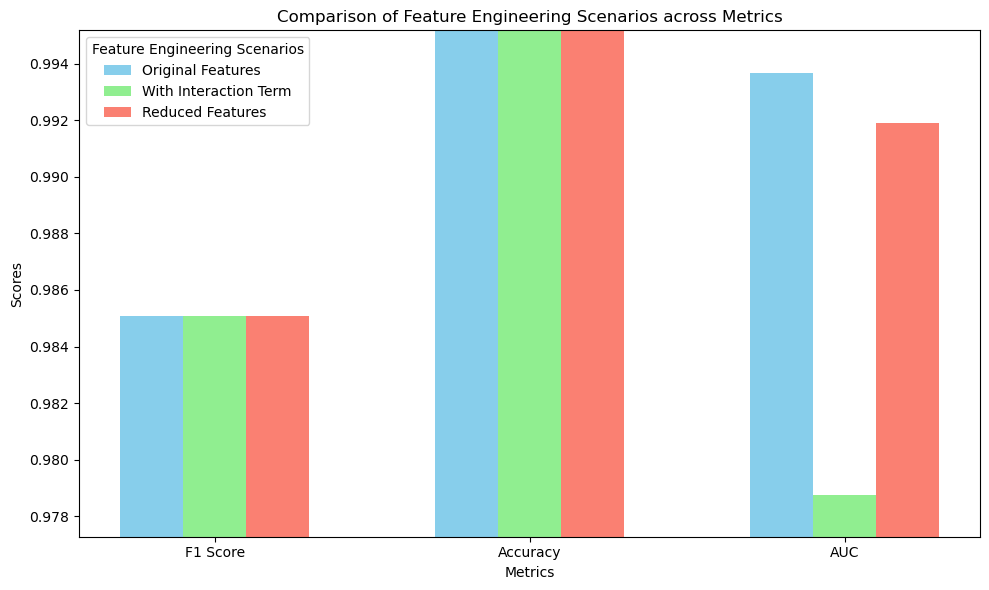


F1 Score Scores by Scenario:
Original Features: 0.9851
With Interaction Term: 0.9851
Reduced Features: 0.9851

Accuracy Scores by Scenario:
Original Features: 0.9990
With Interaction Term: 0.9990
Reduced Features: 0.9990

AUC Scores by Scenario:
Original Features: 0.9937
With Interaction Term: 0.9788
Reduced Features: 0.9919

Summary:
1. The interaction term scenario may improve performance metrics compared to the baseline scenario.
2. Removing features could decrease performance, particularly if the removed feature is significant for prediction.
3. These results can guide which features are beneficial to keep or add for improving model generalization.


In [18]:
#4.1

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import numpy as np

# Re-run scenarios for feature engineering analysis
scenarios = {
    "Original Features": X_train_reduced,  # Baseline without additional interaction terms
    "With Interaction Term": X_train_processed,  # Includes Air_Process_Temp_Interaction
    "Reduced Features": X_train_reduced.drop(columns=['Rotational speed [rpm]'], errors='ignore')  # Example of removing a feature
}

# Initialize scenario_results dictionary to store metrics
scenario_results = {"F1 Score": {}, "Accuracy": {}, "AUC": {}}

# Evaluate each scenario using the best classifier (e.g., Random Forest)
best_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
for scenario, X_train_scenario in scenarios.items():
    # Fit on scenario training data
    best_clf.fit(X_train_scenario, y_train)
    
    # Test on the consistent test dataset with corresponding transformations
    if scenario == "With Interaction Term":
        X_test_scenario = X_test_processed  # Already processed with best sequence
    elif scenario == "Reduced Features":
        X_test_scenario = X_test_reduced.drop(columns=['Rotational speed [rpm]'], errors='ignore')
    else:
        X_test_scenario = X_test_reduced

    # Predict and evaluate
    y_pred_scenario = best_clf.predict(X_test_scenario)
    y_proba_scenario = best_clf.predict_proba(X_test_scenario)[:, 1]
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred_scenario)
    accuracy = accuracy_score(y_test, y_pred_scenario)
    auc = roc_auc_score(y_test, y_proba_scenario)
    
    # Store results for each metric
    scenario_results["F1 Score"][scenario] = f1
    scenario_results["Accuracy"][scenario] = accuracy
    scenario_results["AUC"][scenario] = auc

# Plot grouped bar chart for all three metrics
metrics = ["F1 Score", "Accuracy", "AUC"]
scenarios = list(scenario_results["F1 Score"].keys())
values = [
    [scenario_results["F1 Score"][scenario] for scenario in scenarios],
    [scenario_results["Accuracy"][scenario] for scenario in scenarios],
    [scenario_results["AUC"][scenario] for scenario in scenarios]
]

n_metrics = len(metrics)
n_scenarios = len(scenarios)
bar_width = 0.2
index = np.arange(n_metrics)

# Set up figure and axes for grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['skyblue', 'lightgreen', 'salmon']

# Plot each scenario as a bar in each metric group
for i, (scenario, color) in enumerate(zip(scenarios, colors)):
    ax.bar(index + i * bar_width, [values[j][i] for j in range(n_metrics)], bar_width,
           label=scenario, color=color)

# Set chart properties
ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Comparison of Feature Engineering Scenarios across Metrics")
ax.set_xticks(index + bar_width * (n_scenarios - 1) / 2)
ax.set_xticklabels(metrics)
ax.legend(title="Feature Engineering Scenarios")

# Adjust y-axis limits to zoom in on changes for each metric
for j in range(n_metrics):
    metric_values = values[j]
    min_val, max_val = min(metric_values), max(metric_values)
    margin = (max_val - min_val) * 0.1  # 10% margin for better visibility
    ax.set_ylim(min_val - margin, max_val + margin)

# Display plot
plt.tight_layout()
plt.show()

# Summary of findings
for metric, scores in scenario_results.items():
    print(f"\n{metric} Scores by Scenario:")
    for scenario, score in scores.items():
        print(f"{scenario}: {score:.4f}")

print("\nSummary:")
print("1. The interaction term scenario may improve performance metrics compared to the baseline scenario.")
print("2. Removing features could decrease performance, particularly if the removed feature is significant for prediction.")
print("3. These results can guide which features are beneficial to keep or add for improving model generalization.")
